<a href="https://colab.research.google.com/github/AliGhadirii/Fuzzy-Deep-Learning-Text-Classification/blob/main/Final_rulebase_Sentiment_V7_3class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Set up Directory { run: "auto"}
import os
from IPython.display import clear_output
from google.colab import drive 
from IPython.display import clear_output
drive.mount('/content/gdrive')
working_directory = 'My Drive' #@param {type:"string"}
wd="/content/gdrive/"+working_directory
os.chdir(wd)

dirpath = os.getcwd()
print("current directory is : " + dirpath)


Mounted at /content/gdrive
current directory is : /content/gdrive/My Drive


#Training Model_1 : BERT_base

In [ ]:
! pip install transformers -q
! pip install emoji --upgrade -q
! pip install Unidecode -q

     |████████████████████████████████| 2.0MB 6.1MB/s 
     |████████████████████████████████| 3.2MB 36.4MB/s 
     |████████████████████████████████| 890kB 41.0MB/s 
     |████████████████████████████████| 133kB 5.8MB/s 
     |████████████████████████████████| 245kB 4.2MB/s 


In [ ]:
import re
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from typing import *
from tqdm.notebook import tqdm
from sklearn.utils.extmath import softmax
from sklearn import model_selection
from sklearn.metrics import classification_report, f1_score

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
from transformers import AdamW

In [ ]:
import emoji
import regex
import numpy as np
import os
import random

In [ ]:
def seed_all(seed = 42):
  """
  Fix seed for reproducibility
  """
  random.seed(seed)  
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)

In [ ]:
class config:
  SEED = 42
  KFOLD = 5
  TRAIN_FILE = 'train.csv'
  VAL_FILE =  'valid.csv'
  TEST_FILE = 'test_2.csv'
  OOF_FILE = 'oof.csv'
  MAX_LEN = 40
  MODEL = 'bert-base-uncased'
  TOKENIZER = transformers.AutoTokenizer.from_pretrained(MODEL)
  EPOCHS = 5
  TRAIN_BATCH_SIZE = 16
  VALID_BATCH_SIZE = 16
  DEVICE = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [ ]:
class AverageMeter:
    """
    Computes and stores the average and current value
    Source : https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch/
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class EarlyStopping:
    """
    Early stopping utility
    Source : https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch/
    """
    
    def __init__(self, patience=7, mode="max", delta=0.001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print('Validation score improved ({} --> {}). Saving model!'.format(self.val_score, epoch_score))
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [ ]:
def process_data(text, tokenizer, max_len, label):

  token_ids = tokenizer.encode(text, add_special_tokens=True)
  mask = [1] * len(token_ids)

  padding = max_len - len(token_ids)
  
  if padding>=0:
    token_ids = token_ids + ([0] * padding)
    mask = mask + ([0] * padding)
  else:
    token_ids = token_ids[0:max_len]
    mask = mask[0:max_len]

  assert len(token_ids)==max_len
  assert len(mask)==max_len

  return {'text':text,
          'ids':token_ids,
          'mask':mask,
          'label':label
          }

In [ ]:
class Dataset:
    def __init__(self, text, label):
        self.text = text
        self.label = label
        self.tokenizer = config.TOKENIZER
        self.max_len = config.MAX_LEN
    
    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        data = process_data(
            self.text[item], 
            self.tokenizer,
            self.max_len,
            self.label[item],
        )

        return {
            'ids': torch.tensor(data["ids"], dtype=torch.long),
            'mask': torch.tensor(data["mask"], dtype=torch.long),
            'text': data['text'],
            'label': data['label'],
        }

In [ ]:
def train_fn(data_loader, model, optimizer, device):
  model.train()
  losses = AverageMeter()
  tk0 = tqdm(data_loader, total=len(data_loader))
  
  for bi, d in enumerate(tk0):
    ids = d['ids']
    mask = d['mask']
    label = d['label']

    ids = ids.to(device, dtype=torch.long)
    label = label.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)

    model.zero_grad()
    loss, logits = model(input_ids=ids, attention_mask=mask, labels=label)

    loss.backward()
    optimizer.step()

    losses.update(loss.item(), ids.size(0))
    tk0.set_postfix(loss=losses.avg)


In [ ]:
def eval_fn(data_loader, model, device):
  model.eval()
  losses = AverageMeter()
  tk0 = tqdm(data_loader, total=len(data_loader))
  yt, yp = [], []

  for bi, d in enumerate(tk0):
    ids = d['ids']
    mask = d['mask']
    label = d['label']

    ids = ids.to(device, dtype=torch.long)
    label = label.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)

    with torch.no_grad():
      loss, logits = model(input_ids=ids, attention_mask=mask, labels=label)        
       
    
    logits = logits.detach().cpu().numpy()

    preds = softmax(logits)
    pred_labels = np.argmax(preds, axis=1).flatten()
    ground_labels = label.to('cpu').numpy()

    yt = yt + ground_labels.tolist()
    yp = yp + pred_labels.tolist()

    losses.update(loss.item(), ids.size(0))
    tk0.set_postfix(loss=losses.avg)

  return f1_score(yt, yp, average='weighted')


In [ ]:
def test_fn(data_loader, model, device):
  model.eval()
  tk0 = tqdm(data_loader, total=len(data_loader))
  test_preds = []

  for bi, d in enumerate(tk0):
    ids = d['ids']
    mask = d['mask']
    label = d['label']
    
    ids = ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    label = label.to(device, dtype=torch.long)

    with torch.no_grad():
      _, logits = model(input_ids=ids, attention_mask=mask, labels=label)        
    
    logits = logits.detach().cpu().numpy()
    preds = softmax(logits)     
    test_preds = test_preds + preds.tolist()

  return test_preds

In [ ]:
def run(df_train, df_val, fold=None):
  train_dataset = Dataset(
        text = df_train.full_text.values,
        label = df_train.Sentiment_Label.values,
    )
  
  valid_dataset = Dataset(
      text = df_val.full_text.values,
      label = df_val.Sentiment_Label.values,
    )
  
  train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN_BATCH_SIZE,
        num_workers=4
    )

  valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=config.VALID_BATCH_SIZE,
        num_workers=2
    )
  
  
  model = transformers.BertForSequenceClassification.from_pretrained(config.MODEL, num_labels=3, return_dict=False)
  device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
  model.to(device)

  lr = 2e-5
  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
  ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=lr)

  es = EarlyStopping(patience=2, mode="max")

  print('Starting training....')
  for epoch in range(config.EPOCHS):
    train_fn(train_data_loader, model, optimizer, device)
    valid_loss = eval_fn(valid_data_loader, model, device)
    print(f'Epoch :{epoch + 1} | Validation Score :{valid_loss}')
    if fold is None:
      es(valid_loss, model, model_path="model.bin")
    else:
      es(valid_loss, model, model_path=f"model_{fold}.bin")
    if es.early_stop:
      print('Early stopping')
      break

  print('Predicting for OOF')
  if fold is None:
    model.load_state_dict(torch.load('model.bin'))
  else:
    model.load_state_dict(torch.load(f'model_{fold}.bin'))
    
  model.to(device)
  
  test_predictions = test_fn(valid_data_loader, model, device)
  return test_predictions

In [ ]:
def run_fold(fold_idx):
  """
    Perform k-fold cross-validation
  """

  seed_all()
  scores = pd.DataFrame()

  df_train = pd.read_csv(config.TRAIN_FILE)
  df_val = pd.read_csv(config.VAL_FILE)
  
  # concatenating train and validation set
  train = pd.concat([df_train, df_val]).reset_index()
  
  # dividing folds
  kf = model_selection.StratifiedKFold(n_splits=config.KFOLD, shuffle=False, random_state=config.SEED)
  idx = None

  for fold, (train_idx, val_idx) in enumerate(kf.split(X=train, y=train.Sentiment_Label.values)):
      train.loc[val_idx, 'kfold'] = fold
      if fold==fold_idx:
        idx = val_idx

  if os.path.isfile(config.OOF_FILE):
    scores = pd.read_csv(config.OOF_FILE)
    print('Found oof file')
  else:
    scores = train.copy()
    scores['oof'] = 0
    scores.to_csv(config.OOF_FILE, index=False)
    print('Created oof file')
  
  df_train = train[train.kfold!=fold_idx]
  df_val = train[train.kfold==fold_idx]

  y = run(df_train, df_val, fold_idx)
  pred_label = np.argmax(y, axis=1).flatten()
  scores.loc[idx, 'oof'] = pred_label
  
  scores.to_csv(config.OOF_FILE, index=False)


In [ ]:
run_fold(0)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Created oof file


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or w

Starting training....



Epoch :1 | Validation Score :0.8076590163228912
Validation score improved (-inf --> 0.8076590163228912). Saving model!



Epoch :2 | Validation Score :0.8010700515759133
EarlyStopping counter: 1 out of 2



Epoch :3 | Validation Score :0.794082744697871
EarlyStopping counter: 2 out of 2
Early stopping
Predicting for OOF


In [ ]:
# df_val = pd.read_csv(config.VAL_FILE)

# valid_dataset = Dataset(
#     text = df_val.full_text.values,
#     label = df_val.Sentiment_Label.values,
#   )

# valid_data_loader = torch.utils.data.DataLoader(
#         valid_dataset,
#         batch_size=config.VALID_BATCH_SIZE,
#         num_workers=2
#     )

# model = transformers.BertForSequenceClassification.from_pretrained(config.MODEL, num_labels=3, return_dict=False)
# device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# model.load_state_dict(torch.load('model_0.bin'))
# model.to(device)
# test_predictions = test_fn(valid_data_loader, model, device)
# pred_label = np.argmax(test_predictions, axis=1).flatten()
# df_val['pred_label'] = pred_label
# temp = df_val[df_val['Sentiment_Label'] != df_val['pred_label']]
# temp
temp.to_csv('eval.csv', index=False)

In [ ]:
run_fold(1)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Found oof file


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Starting training....



Epoch :1 | Validation Score :0.807780723458744
Validation score improved (-inf --> 0.807780723458744). Saving model!



Epoch :2 | Validation Score :0.8066207483834981
EarlyStopping counter: 1 out of 2



Epoch :3 | Validation Score :0.7989863644625798
EarlyStopping counter: 2 out of 2
Early stopping
Predicting for OOF


In [ ]:
run_fold(2)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Found oof file


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Starting training....



Epoch :1 | Validation Score :0.807918600469505
Validation score improved (-inf --> 0.807918600469505). Saving model!



Epoch :2 | Validation Score :0.8082996499871115
EarlyStopping counter: 1 out of 2



Epoch :3 | Validation Score :0.7928176002077414
EarlyStopping counter: 2 out of 2
Early stopping
Predicting for OOF


In [ ]:
run_fold(3)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Found oof file


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Starting training....



Epoch :1 | Validation Score :0.7983176511665255
Validation score improved (-inf --> 0.7983176511665255). Saving model!



Epoch :2 | Validation Score :0.7897406285909349
EarlyStopping counter: 1 out of 2



Epoch :3 | Validation Score :0.7867248059618113
EarlyStopping counter: 2 out of 2
Early stopping
Predicting for OOF


In [ ]:
run_fold(4)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Found oof file


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Starting training....



Epoch :1 | Validation Score :0.7869780118917878
Validation score improved (-inf --> 0.7869780118917878). Saving model!



Epoch :2 | Validation Score :0.7953702890080961
Validation score improved (0.7869780118917878 --> 0.7953702890080961). Saving model!



Epoch :3 | Validation Score :0.7914818958542914
EarlyStopping counter: 1 out of 2



Epoch :4 | Validation Score :0.7799164920967608
EarlyStopping counter: 2 out of 2
Early stopping
Predicting for OOF


#Training Model_2 : CT_BERT

In [ ]:
os.chdir('../SEN_CTBERT')
print(os.getcwd())

/content/gdrive/My Drive/SEN_CTBERT


In [ ]:
! pip install transformers -q
! pip install emoji --upgrade -q
! pip install Unidecode -q

     |████████████████████████████████| 2.0MB 19.7MB/s 
     |████████████████████████████████| 890kB 25.7MB/s 
     |████████████████████████████████| 3.2MB 47.2MB/s 
     |████████████████████████████████| 133kB 17.5MB/s 
     |████████████████████████████████| 245kB 19.9MB/s 


In [ ]:
import re
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from typing import *
from tqdm.notebook import tqdm
from sklearn.utils.extmath import softmax
from sklearn import model_selection
from sklearn.metrics import classification_report, f1_score

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
from transformers import AdamW

In [ ]:
import emoji
import regex
import numpy as np
import os
import random

In [ ]:
def seed_all(seed = 42):
  """
  Fix seed for reproducibility
  """
  random.seed(seed)  
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)

In [ ]:
class config:
  SEED = 42
  KFOLD = 5
  TRAIN_FILE = 'train.csv'
  VAL_FILE =  'valid.csv'
  TEST_FILE = 'test_2.csv'
  OOF_FILE = 'oof.csv'
  MAX_LEN = 40
  MODEL = 'digitalepidemiologylab/covid-twitter-bert'
  TOKENIZER = transformers.AutoTokenizer.from_pretrained(MODEL)
  EPOCHS = 5
  TRAIN_BATCH_SIZE = 16
  VALID_BATCH_SIZE = 16
  DEVICE = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [ ]:
class AverageMeter:
    """
    Computes and stores the average and current value
    Source : https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch/
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class EarlyStopping:
    """
    Early stopping utility
    Source : https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch/
    """
    
    def __init__(self, patience=7, mode="max", delta=0.001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print('Validation score improved ({} --> {}). Saving model!'.format(self.val_score, epoch_score))
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [ ]:
def process_data(text, tokenizer, max_len, label):

  
  token_ids = tokenizer.encode(text, add_special_tokens=True)
  mask = [1] * len(token_ids)

  padding = max_len - len(token_ids)
  
  if padding>=0:
    token_ids = token_ids + ([0] * padding)
    mask = mask + ([0] * padding)
  else:
    token_ids = token_ids[0:max_len]
    mask = mask[0:max_len]

  
  assert len(token_ids)==max_len
  assert len(mask)==max_len

  return {'text':text,
          'ids':token_ids,
          'mask':mask,
          'label':label
          }

In [ ]:
class Dataset:
    def __init__(self, text, label):
        self.text = text
        self.label = label
        self.tokenizer = config.TOKENIZER
        self.max_len = config.MAX_LEN
    
    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        data = process_data(
            self.text[item], 
            self.tokenizer,
            self.max_len,
            self.label[item],
        )

        return {
            'ids': torch.tensor(data["ids"], dtype=torch.long),
            'mask': torch.tensor(data["mask"], dtype=torch.long),
            'text': data['text'],
            'label': data['label'],
        }

In [ ]:
class FGM():
    """
        Utility for Adversarial Training
        Source: https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/143764
    """
    def __init__(self, model):
        self.model = model
        self.backup = {}

    def attack(self, epsilon=1., emb_name='word_embeddings'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                self.backup[name] = param.data.clone()
                norm = torch.norm(param.grad)
                if norm != 0:
                    r_at = epsilon * param.grad / norm
                    param.data.add_(r_at)

    def restore(self, emb_name='word_embeddings'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                assert name in self.backup
                param.data = self.backup[name]
            self.backup = {}

In [ ]:
def train_fn(data_loader, model, optimizer, device):
  model.train()
  fgm = FGM(model)

  losses = AverageMeter()
  tk0 = tqdm(data_loader, total=len(data_loader))
  
  for bi, d in enumerate(tk0):
    ids = d['ids']
    mask = d['mask']
    label = d['label']

    ids = ids.to(device, dtype=torch.long)
    label = label.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)

    model.zero_grad()
    loss, logits = model(input_ids=ids, attention_mask=mask, labels=label)
    loss.backward()

    fgm.attack() 
    loss_adv, _ = model(input_ids=ids, attention_mask=mask, labels=label)
    loss_adv.backward() 
    fgm.restore()

    optimizer.step()

    losses.update(loss.item(), ids.size(0))
    tk0.set_postfix(loss=losses.avg)


In [ ]:
def eval_fn(data_loader, model, device):
  model.eval()
  losses = AverageMeter()
  tk0 = tqdm(data_loader, total=len(data_loader))
  yt, yp = [], []

  for bi, d in enumerate(tk0):
    ids = d['ids']
    mask = d['mask']
    label = d['label']

    ids = ids.to(device, dtype=torch.long)
    label = label.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)

    with torch.no_grad():
      loss, logits = model(input_ids=ids, attention_mask=mask, labels=label)        
       
    
    logits = logits.detach().cpu().numpy()

    preds = softmax(logits)
    pred_labels = np.argmax(preds, axis=1).flatten()
    ground_labels = label.to('cpu').numpy()

    yt = yt + ground_labels.tolist()
    yp = yp + pred_labels.tolist()

    losses.update(loss.item(), ids.size(0))
    tk0.set_postfix(loss=losses.avg)

  return f1_score(yt, yp, average='weighted')


In [ ]:
def test_fn(data_loader, model, device):
  model.eval()
  tk0 = tqdm(data_loader, total=len(data_loader))
  test_preds = []

  for bi, d in enumerate(tk0):
    ids = d['ids']
    mask = d['mask']
    label = d['label']
    
    ids = ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    label = label.to(device, dtype=torch.long)

    with torch.no_grad():
      _, logits = model(input_ids=ids, attention_mask=mask, labels=label)        
    
    logits = logits.detach().cpu().numpy()
    preds = softmax(logits)     
    test_preds = test_preds + preds.tolist()

  return test_preds

In [ ]:
def run(df_train, df_val, fold=None):
  train_dataset = Dataset(
        text = df_train.full_text.values,
        label = df_train.Sentiment_Label.values,
    )
  
  valid_dataset = Dataset(
      text = df_val.full_text.values,
      label = df_val.Sentiment_Label.values,
    )
  
  train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN_BATCH_SIZE,
        num_workers=4
    )

  valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=config.VALID_BATCH_SIZE,
        num_workers=2
    )
  
  
  model = transformers.BertForSequenceClassification.from_pretrained(config.MODEL, num_labels=3, return_dict=False)
  device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
  model.to(device)

  lr = 2e-5
  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
  ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=lr)

  es = EarlyStopping(patience=2, mode="max")

  print('Starting training....')
  for epoch in range(config.EPOCHS):
    train_fn(train_data_loader, model, optimizer, device)
    valid_loss = eval_fn(valid_data_loader, model, device)
    print(f'Epoch :{epoch + 1} | Validation Score :{valid_loss}')
    if fold is None:
      es(valid_loss, model, model_path="model.bin")
    else:
      es(valid_loss, model, model_path=f"model_{fold}.bin")
    if es.early_stop:
      print('Early stopping')
      break

  print('Predicting for OOF')
  if fold is None:
    model.load_state_dict(torch.load('model.bin'))
  else:
    model.load_state_dict(torch.load(f'model_{fold}.bin'))
    
  model.to(device)
  
  test_predictions = test_fn(valid_data_loader, model, device)
  return test_predictions

In [ ]:
def run_fold(fold_idx):
  """
    Perform k-fold cross-validation
  """

  seed_all()
  scores = pd.DataFrame()

  df_train = pd.read_csv(config.TRAIN_FILE)
  df_val = pd.read_csv(config.VAL_FILE)
  
  # concatenating train and validation set
  train = pd.concat([df_train, df_val]).reset_index()
  
  # dividing folds
  kf = model_selection.StratifiedKFold(n_splits=config.KFOLD, shuffle=False, random_state=config.SEED)
  idx = None

  for fold, (train_idx, val_idx) in enumerate(kf.split(X=train, y=train.Sentiment_Label.values)):
      train.loc[val_idx, 'kfold'] = fold
      if fold==fold_idx:
        idx = val_idx

  if os.path.isfile(config.OOF_FILE):
    scores = pd.read_csv(config.OOF_FILE)
    print('Found oof file')
  else:
    scores = train.copy()
    scores['oof'] = 0
    scores.to_csv(config.OOF_FILE, index=False)
    print('Created oof file')
  
  df_train = train[train.kfold!=fold_idx]
  df_val = train[train.kfold==fold_idx]

  y = run(df_train, df_val, fold_idx)
  pred_label = np.argmax(y, axis=1).flatten()
  scores.loc[idx, 'oof'] = pred_label
  
  scores.to_csv(config.OOF_FILE, index=False)


In [ ]:
run_fold(0)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Found oof file


Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifi

Starting training....



Epoch :1 | Validation Score :0.8061287268133831
Validation score improved (-inf --> 0.8061287268133831). Saving model!



Epoch :2 | Validation Score :0.8047482531131762
EarlyStopping counter: 1 out of 2



Epoch :3 | Validation Score :0.7978145209717917
EarlyStopping counter: 2 out of 2
Early stopping
Predicting for OOF


In [ ]:
run_fold(1)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Found oof file


Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifi

Starting training....



Epoch :1 | Validation Score :0.8140717797774897
Validation score improved (-inf --> 0.8140717797774897). Saving model!



Epoch :2 | Validation Score :0.7996274913336086
EarlyStopping counter: 1 out of 2



Epoch :3 | Validation Score :0.8007758280255339
EarlyStopping counter: 2 out of 2
Early stopping
Predicting for OOF


In [ ]:
run_fold(2)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Found oof file


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifi

Starting training....



Epoch :1 | Validation Score :0.8076563808507622
Validation score improved (-inf --> 0.8076563808507622). Saving model!



Epoch :2 | Validation Score :0.809227234696961
Validation score improved (0.8076563808507622 --> 0.809227234696961). Saving model!



Epoch :3 | Validation Score :0.8001285077932871
EarlyStopping counter: 1 out of 2



Epoch :4 | Validation Score :0.7974775736973218
EarlyStopping counter: 2 out of 2
Early stopping
Predicting for OOF


In [ ]:
run_fold(3)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Found oof file


Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifi

Starting training....



Epoch :1 | Validation Score :0.8001855074938592
Validation score improved (-inf --> 0.8001855074938592). Saving model!


In [ ]:
run_fold(4)

NameError: ignored

#Training Model_3 : RoBERT

In [ ]:
! pip install transformers -q
! pip install emoji --upgrade -q
! pip install Unidecode -q

     |████████████████████████████████| 2.0MB 7.6MB/s 
     |████████████████████████████████| 890kB 16.5MB/s 
     |████████████████████████████████| 3.2MB 56.8MB/s 
     |████████████████████████████████| 133kB 8.4MB/s 
     |████████████████████████████████| 245kB 7.5MB/s 


In [ ]:
import re
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from typing import *
from tqdm.notebook import tqdm
from sklearn.utils.extmath import softmax
from sklearn import model_selection
from sklearn.metrics import classification_report, f1_score

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
from transformers import AdamW

In [ ]:
import emoji
import os
import regex

In [ ]:
def seed_all(seed = 42):
  """
  Fix seed for reproducibility
  """
  # python RNG
  import random
  random.seed(seed)

  # pytorch RNGs
  import torch
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

  # numpy RNG
  import numpy as np
  np.random.seed(seed)

In [ ]:
class config:
  SEED = 42
  KFOLD = 5
  
  TRAIN_FILE = 'train.csv'
  VAL_FILE =  'valid.csv'
  TEST_FILE = 'test_2.csv'
  OOF_FILE = 'oof.csv'
  MAX_LEN = 40
  MODEL = 'roberta-large'
  TOKENIZER = transformers.AutoTokenizer.from_pretrained(MODEL)
  EPOCHS = 5
  TRAIN_BATCH_SIZE = 16
  VALID_BATCH_SIZE = 16
  DEVICE = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [ ]:
class AverageMeter:
    """
    Computes and stores the average and current value
    Source : https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch/
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class EarlyStopping:
    """
    Early stopping utility
    Source : https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch/
    """
    
    def __init__(self, patience=7, mode="max", delta=0.001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print('Validation score improved ({} --> {}). Saving model!'.format(self.val_score, epoch_score))
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [ ]:
def process_data(text, tokenizer, max_len, label):
  
  
  token_ids = tokenizer.encode(text, add_special_tokens=True)
  mask = [1] * len(token_ids)

  padding = max_len - len(token_ids)
  
  if padding>=0:
    token_ids = token_ids + ([0] * padding)
    mask = mask + ([0] * padding)
  else:
    token_ids = token_ids[0:max_len]
    mask = mask[0:max_len]



  assert len(token_ids)==max_len
  assert len(mask)==max_len

  return {'text':text,
          'ids':token_ids,
          'mask':mask,
          'label':label
          }

In [ ]:
class Dataset:
    def __init__(self, text, label):
        self.text = text
        self.label = label
        self.tokenizer = config.TOKENIZER
        self.max_len = config.MAX_LEN
    
    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        data = process_data(
            self.text[item], 
            self.tokenizer,
            self.max_len,
            self.label[item],
        )

        return {
            'ids': torch.tensor(data["ids"], dtype=torch.long),
            'mask': torch.tensor(data["mask"], dtype=torch.long),
            'text': data['text'],
            'label': data['label'],
        }

In [ ]:
def train_fn(data_loader, model, optimizer, device):
  model.train()
  losses = AverageMeter()
  tk0 = tqdm(data_loader, total=len(data_loader))
  
  for bi, d in enumerate(tk0):
    ids = d['ids']
    mask = d['mask']
    label = d['label']

    ids = ids.to(device, dtype=torch.long)
    label = label.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)

    model.zero_grad()
    loss, logits = model(input_ids=ids, attention_mask=mask, labels=label)

    loss.backward()
    optimizer.step()

    losses.update(loss.item(), ids.size(0))
    tk0.set_postfix(loss=losses.avg)


In [ ]:
def eval_fn(data_loader, model, device):
  model.eval()
  losses = AverageMeter()
  tk0 = tqdm(data_loader, total=len(data_loader))
  yt, yp = [], []

  for bi, d in enumerate(tk0):
    ids = d['ids']
    mask = d['mask']
    label = d['label']

    ids = ids.to(device, dtype=torch.long)
    label = label.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)

    with torch.no_grad():
      loss, logits = model(input_ids=ids, attention_mask=mask, labels=label)        
       
    
    logits = logits.detach().cpu().numpy()

    preds = softmax(logits)
    pred_labels = np.argmax(preds, axis=1).flatten()
    ground_labels = label.to('cpu').numpy()

    yt = yt + ground_labels.tolist()
    yp = yp + pred_labels.tolist()

    losses.update(loss.item(), ids.size(0))
    tk0.set_postfix(loss=losses.avg)

  return f1_score(yt, yp)


In [ ]:
def run(df_train, df_val, fold=None):
  train_dataset = Dataset(
        text = df_train.Text.values,
        label = df_train.Label.values,
    )
  
  valid_dataset = Dataset(
      text = df_val.Text.values,
      label = df_val.Label.values,
    )
  
  train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN_BATCH_SIZE,
        num_workers=4
    )

  valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=config.VALID_BATCH_SIZE,
        num_workers=2
    )
  
  
  model = transformers.RobertaForSequenceClassification.from_pretrained(config.MODEL, num_labels=2, return_dict=False)
  device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
  model.to(device)

  lr = 2e-5
  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
  ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=lr)

  es = EarlyStopping(patience=2, mode="max")

  print('Starting training....')
  for epoch in range(config.EPOCHS):
    train_fn(train_data_loader, model, optimizer, device)
    valid_loss = eval_fn(valid_data_loader, model, device)
    print(f'Epoch :{epoch + 1} | Validation Score :{valid_loss}')
    if fold is None:
      es(valid_loss, model, model_path=f"model.bin")
    else:
      es(valid_loss, model, model_path=f"model_{fold}.bin")
    if es.early_stop:
      print('Early stopping')
      break

  print('Predicting for OOF')
  if fold is None:
    model.load_state_dict(torch.load('model.bin'))
  else:
    model.load_state_dict(torch.load(f'model_{fold}.bin'))
    
  model.to(device)
  
  test_predictions = test_fn(valid_data_loader, model, device)
  return test_predictions

In [ ]:
def run_fold(fold_idx):
  """
    Perform k-fold cross-validation
  """

  seed_all()
  scores = pd.DataFrame()

  df_train = pd.read_csv(config.TRAIN_FILE)
  df_val = pd.read_csv(config.VAL_FILE)
  
  # concatenating train and validation set
  train = pd.concat([df_train, df_val]).reset_index()
  
  # dividing folds
  kf = model_selection.StratifiedKFold(n_splits=config.KFOLD, shuffle=False, random_state=config.SEED)
  idx = None

  for fold, (train_idx, val_idx) in enumerate(kf.split(X=train, y=train.Label.values)):
      train.loc[val_idx, 'kfold'] = fold
      if fold==fold_idx:
        idx = val_idx

  if os.path.isfile(config.OOF_FILE):
    scores = pd.read_csv(config.OOF_FILE)
    print('Found oof file')
  else:
    scores = train.copy()
    scores['oof'] = 0
    scores.to_csv(config.OOF_FILE, index=False)
    print('Created oof file')
  
  df_train = train[train.kfold!=fold_idx]
  df_val = train[train.kfold==fold_idx]

  y = run(df_train, df_val, fold_idx)
  scores.loc[idx, 'oof'] = y
  
  scores.to_csv(config.OOF_FILE, index=False)


In [ ]:
run_fold(0)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Found oof file


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

Starting training....


Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors



Epoch :1 | Validation Score :0.9369863013698629
Validation score improved (-inf --> 0.9369863013698629). Saving model!


Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors



Epoch :2 | Validation Score :0.9506254114549045
Validation score improved (0.9369863013698629 --> 0.9506254114549045). Saving model!


Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors



Epoch :3 | Validation Score :0.9565217391304348
Validation score improved (0.9506254114549045 --> 0.9565217391304348). Saving model!


Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors



Epoch :4 | Validation Score :0.9560513860716701
EarlyStopping counter: 1 out of 2


Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors



Epoch :5 | Validation Score :0.9661129568106313
Validation score improved (0.9565217391304348 --> 0.9661129568106313). Saving model!
Predicting for OOF


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
run_fold(1)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Found oof file


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

Starting training....


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors



Epoch :1 | Validation Score :0.9550637156270958
Validation score improved (-inf --> 0.9550637156270958). Saving model!


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors



Epoch :2 | Validation Score :0.9609882964889467
Validation score improved (0.9550637156270958 --> 0.9609882964889467). Saving model!


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors



Epoch :3 | Validation Score :0.960797342192691
EarlyStopping counter: 1 out of 2


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors



Epoch :4 | Validation Score :0.9568679495686795
EarlyStopping counter: 2 out of 2
Early stopping
Predicting for OOF


In [ ]:
run_fold(2)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Found oof file


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

Starting training....


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors



Epoch :1 | Validation Score :0.9486679662118258
Validation score improved (-inf --> 0.9486679662118258). Saving model!


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors



Epoch :2 | Validation Score :0.9523178807947019
Validation score improved (0.9486679662118258 --> 0.9523178807947019). Saving model!


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors



Epoch :3 | Validation Score :0.9554973821989529
Validation score improved (0.9523178807947019 --> 0.9554973821989529). Saving model!


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors



Epoch :4 | Validation Score :0.9572763684913218
Validation score improved (0.9554973821989529 --> 0.9572763684913218). Saving model!


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors



Epoch :5 | Validation Score :0.9609164420485176
Validation score improved (0.9572763684913218 --> 0.9609164420485176). Saving model!
Predicting for OOF


Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
run_fold(3)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Found oof file


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

Starting training....


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors



Epoch :1 | Validation Score :0.942159383033419
Validation score improved (-inf --> 0.942159383033419). Saving model!


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors



Epoch :2 | Validation Score :0.9465346534653465
Validation score improved (0.942159383033419 --> 0.9465346534653465). Saving model!


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors



Epoch :3 | Validation Score :0.951058201058201
Validation score improved (0.9465346534653465 --> 0.951058201058201). Saving model!


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors



Epoch :4 | Validation Score :0.9433701657458563
EarlyStopping counter: 1 out of 2


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors



Epoch :5 | Validation Score :0.9569892473118279
Validation score improved (0.951058201058201 --> 0.9569892473118279). Saving model!
Predicting for OOF


Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
run_fold(4)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Found oof file


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

Starting training....


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors



Epoch :1 | Validation Score :0.9321692411014103
Validation score improved (-inf --> 0.9321692411014103). Saving model!


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors



Epoch :2 | Validation Score :0.9170013386880856
EarlyStopping counter: 1 out of 2


Token indices sequence length is longer than the specified maximum sequence length for this model (1035 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1189 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors



Epoch :3 | Validation Score :0.9297297297297297
EarlyStopping counter: 2 out of 2
Early stopping
Predicting for OOF


# Test the Hole model using Fuzzy Rulebased system

In [ ]:
import torch.nn.functional as F

def test_fn(data_loader, model, device):
  global num_data
  model.eval()
  tk0 = tqdm(data_loader, total=len(data_loader))
  test_preds = []

  temp_data = np.zeros([num_data, 1, 3])
  all_logits = []

  for bi, d in enumerate(tk0):
    ids = d['ids']
    mask = d['mask']
    label = d['label']
    
    ids = ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    label = label.to(device, dtype=torch.long)

    with torch.no_grad():
      _, logits = model(input_ids=ids, attention_mask=mask, labels=label)   
    all_logits.append(logits)
    
    logits = logits.detach().cpu().numpy()
    preds = softmax(logits)        
    test_preds = test_preds + preds.tolist()

  all_logits = torch.cat(all_logits, dim=0)
  probs = F.softmax(all_logits, dim=1).cpu().numpy()
  np.copyto(temp_data, probs.reshape(num_data, 1, 3))

  return np.array(test_preds), temp_data

In [ ]:
num_classes = 3

In [ ]:
os.chdir('SEN_ROBERT')
df = pd.read_csv(config.TEST_FILE)

test_dataset = Dataset(
      text = df.full_text.values,
      label = df.Sentiment_Label.values,
    )
  
test_data_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=config.VALID_BATCH_SIZE,
      num_workers=4
  )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


##Model_1

In [ ]:
num_data = len(df['Sentiment_Label'].values)
temp_test_data_1 = np.zeros([num_data, 1, num_classes])

scores = {}
T_datas = {}

model = transformers.BertForSequenceClassification.from_pretrained(config.MODEL, num_labels=3, return_dict=False)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
model.to(device)

for i in range(config.KFOLD):
  model.load_state_dict(torch.load(f'model_{i}.bin'))
  y_preds, temp_test_data = test_fn(test_data_loader, model, device)
  scores[f'prob_{i}'] = y_preds
  T_datas[f'prob_{i}'] = temp_test_data

scores['avg'] = (scores['prob_0'] + scores['prob_1'] + scores['prob_2'] + scores['prob_3'] + scores['prob_4'])/5
scores['preds'] = np.argmax(scores['avg'], axis=1).flatten()
df['pred_1'] = scores['preds']

T_datas['data_avg'] = (T_datas['prob_0'] + T_datas['prob_1'] + T_datas['prob_2'] + T_datas['prob_3'] + T_datas['prob_4'])/5

np.copyto(temp_test_data_1, T_datas['data_avg'])
from numpy import savetxt, loadtxt


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored

In [ ]:
temp_test_data_1 = temp_test_data_1.reshape(temp_test_data_1.shape[0], temp_test_data_1.shape[2])
temp_test_data_1.shape
savetxt('temp_test_data_1.csv', temp_test_data_1, delimiter=',')

In [ ]:
print(classification_report(scores['preds'], df['Sentiment_Label'].values, digits=4))

              precision    recall  f1-score   support

           0     0.8689    0.8859    0.8773      2357
           1     0.6566    0.6650    0.6608      1012
           2     0.7963    0.7387    0.7664       815

    accuracy                         0.8038      4184
   macro avg     0.7739    0.7632    0.7682      4184
weighted avg     0.8034    0.8038    0.8033      4184



##Model_2

In [ ]:
os.chdir('../SEN_CTBERT')


num_data = len(df['Sentiment_Label'].values)
temp_test_data_2 = np.zeros([num_data, 1, num_classes])

scores = {}
T_datas = {}

model = transformers.BertForSequenceClassification.from_pretrained(config.MODEL, num_labels=3, return_dict=False)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
model.to(device)

for i in range(config.KFOLD):
  model.load_state_dict(torch.load(f'model_{i}.bin'))
  y_preds, temp_test_data = test_fn(test_data_loader, model, device)
  scores[f'prob_{i}'] = y_preds
  T_datas[f'prob_{i}'] = temp_test_data

scores['avg'] = (scores['prob_0'] + scores['prob_1'] + scores['prob_2'] + scores['prob_3'] + scores['prob_4'])/5
scores['preds'] = np.argmax(scores['avg'], axis=1).flatten()
df['pred_2'] = scores['preds']
T_datas['data_avg'] = (T_datas['prob_0'] + T_datas['prob_1'] + T_datas['prob_2'] + T_datas['prob_3'] + T_datas['prob_4'])/5

np.copyto(temp_test_data_2, T_datas['data_avg'])


Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifi

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#temp_test_data_2 = temp_test_data_2.reshape(temp_test_data_2.shape[0], temp_test_data_2.shape[2])
temp_test_data_2.shape
savetxt('temp_test_data_2.csv', temp_test_data_2, delimiter=',')

In [ ]:
print(classification_report(df['pred_2'], df['Sentiment_Label'].values, digits=4))

              precision    recall  f1-score   support

           0     0.8935    0.8728    0.8830      2460
           1     0.5961    0.7197    0.6521       849
           2     0.8347    0.7211    0.7738       875

    accuracy                         0.8100      4184
   macro avg     0.7747    0.7712    0.7696      4184
weighted avg     0.8208    0.8100    0.8133      4184



##Model_3

In [ ]:
#os.chdir('../SEN_ROBERT')


num_data = len(df['Sentiment_Label'].values)
temp_test_data_3 = np.zeros([num_data, 1, num_classes])

scores = {}
T_datas = {}


model = transformers.RobertaForSequenceClassification.from_pretrained(config.MODEL, num_labels=3, return_dict=False)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
model.to(device)

for i in range(config.KFOLD):
  model.load_state_dict(torch.load(f'model_{i}.bin'))
  y_preds, temp_test_data = test_fn(test_data_loader, model, device)
  scores[f'prob_{i}'] = y_preds
  T_datas[f'prob_{i}'] = temp_test_data

scores['avg'] = (scores['prob_0'] + scores['prob_1'] + scores['prob_2'] + scores['prob_3'] + scores['prob_4'])/5
scores['preds'] = np.argmax(scores['avg'], axis=1).flatten()
df['pred_3'] = scores['preds']
T_datas['data_avg'] = (T_datas['prob_0'] + T_datas['prob_1'] + T_datas['prob_2'] + T_datas['prob_3'] + T_datas['prob_4'])/5

np.copyto(temp_test_data_3, T_datas['data_avg'])

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(classification_report(df['pred_3'], df['Sentiment_Label'].values, digits=4))

              precision    recall  f1-score   support

           0     0.8760    0.8904    0.8832      2364
           1     0.6390    0.6976    0.6670       939
           2     0.8373    0.7185    0.7734       881

    accuracy                         0.8109      4184
   macro avg     0.7841    0.7688    0.7745      4184
weighted avg     0.8147    0.8109    0.8115      4184



In [ ]:
#df['check_1'] = df['Sentiment_Label'] == df['pred_1'] 
#df['check_2'] = df['Sentiment_Label'] == df['pred_2'] 
#df['check_3'] = df['Sentiment_Label'] == df['pred_3'] 
#df['check_4'] = (df['check_1'] | df['check_2'] | df['check_3'])
df.to_csv('result2.csv', index=False)

In [ ]:
#temp_test_data_3 = temp_test_data_3.reshape(temp_test_data_3.shape[0], temp_test_data_3.shape[2])
from numpy import savetxt, loadtxt
temp_test_data_3.shape
savetxt('temp_test_data_3.csv', temp_test_data_3, delimiter=',')

In [ ]:
from numpy import savetxt, loadtxt
from sklearn.metrics import classification_report, f1_score
import pandas as pd
df = pd.read_csv('result.csv')
temp_test_data_1 = loadtxt('temp_test_data_1.csv', delimiter=',')
temp_test_data_2 = loadtxt('temp_test_data_2.csv', delimiter=',')
temp_test_data_3 = loadtxt('temp_test_data_3.csv', delimiter=',')
print(temp_test_data_1.shape)
print(temp_test_data_2.shape)
print(temp_test_data_3.shape)

(4184, 3)
(4184, 3)
(4184, 3)


##Calculating weights

/content/gdrive/My Drive/fuzzy_system/fuzzy_set.py:59: RuntimeWarning: divide by zero encountered in true_divide
  t1fs._dom = np.round(np.minimum(np.maximum(np.minimum((t1fs._domain-a)/(b-a), (d-t1fs._domain)/(d-c)), 0), 1), t1fs._precision)
/content/gdrive/My Drive/fuzzy_system/fuzzy_set.py:59: RuntimeWarning: invalid value encountered in true_divide
  t1fs._dom = np.round(np.minimum(np.maximum(np.minimum((t1fs._domain-a)/(b-a), (d-t1fs._domain)/(d-c)), 0), 1), t1fs._precision)


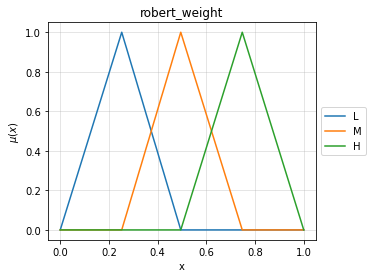

/content/gdrive/My Drive/fuzzy_system/fuzzy_set.py:118: RuntimeWarning: invalid value encountered in double_scalars
  return num/den


In [ ]:
#os.chdir('..')
from fuzzy_system.fuzzy_variable_output import FuzzyOutputVariable
from fuzzy_system.fuzzy_variable_input import FuzzyInputVariable
from fuzzy_system.fuzzy_system import FuzzySystem
import numpy as np

word_len = FuzzyInputVariable('word_len', 11, 40, 29)
word_len.add_triangular('L', 11, 15 ,20)
word_len.add_triangular('M', 11, 20, 25)
word_len.add_trapezoidal('H', 11, 25, 40, 40)

similarity = FuzzyInputVariable('similarity', 0.00, 1.00, 100)
similarity.add_triangular('L', 0.00, 0.08, 0.13)
similarity.add_triangular('M', 0.03, 0.11, 0.15)
similarity.add_trapezoidal('H', 0.00, 0.16, 1.00, 1.00)

bert_weight = FuzzyOutputVariable('bert_weight', 0.00, 1.00, 100)
bert_weight.add_triangular('L', 0.00, 0.25, 0.50)
bert_weight.add_triangular('M', 0.25, 0.50, 0.75)
bert_weight.add_triangular('H', 0.50, 0.75, 1.00)

ctbert_weight = FuzzyOutputVariable('ctbert_weight', 0.00, 1.00, 100)
ctbert_weight.add_triangular('L', 0.00, 0.25, 0.50)
ctbert_weight.add_triangular('M', 0.25, 0.50, 0.75)
ctbert_weight.add_triangular('H',0.50, 0.75, 1.00)

robert_weight = FuzzyOutputVariable('robert_weight', 0.00, 1.00, 100)
robert_weight.add_triangular('L', 0.00, 0.25, 0.50)
robert_weight.add_triangular('M', 0.25, 0.50, 0.75)
robert_weight.add_triangular('H',0.50, 0.75, 1.00)

system = FuzzySystem()
system.add_input_variable(word_len)
system.add_input_variable(similarity)
system.add_output_variable(bert_weight)
system.add_output_variable(ctbert_weight)
system.add_output_variable(robert_weight)

system.add_rule(
    { 'word_len':'M',
      'similarity':'H' },

    { 'bert_weight':'L',
      'ctbert_weight':'H',
      'robert_weight':'M'})


system.add_rule(
    { 'word_len':'H',
      'similarity':'H' },

    { 'bert_weight':'L',
      'ctbert_weight':'H',
      'robert_weight':'M'})

system.add_rule(
    { 'word_len':'L',
      'similarity':'M' },

    { 'bert_weight':'M',
      'ctbert_weight':'M',
      'robert_weight':'M'})

system.add_rule(
    { 'word_len':'M',
      'similarity':'M' },

    { 'bert_weight':'L',
      'ctbert_weight':'M',
      'robert_weight':'H'})

system.add_rule(
    { 'word_len':'H',
      'similarity':'M' },

    { 'bert_weight':'L',
      'ctbert_weight':'L',
      'robert_weight':'H'})

system.add_rule(
    { 'word_len':'L',
      'similarity':'L' },

    { 'bert_weight':'M',
      'ctbert_weight':'M',
      'robert_weight':'H'})

system.add_rule(
    { 'word_len':'M',
      'similarity':'L' },

    { 'bert_weight':'L',
      'ctbert_weight':'L',
      'robert_weight':'H'})

system.add_rule(
    { 'word_len':'H',
      'similarity':'L' },

    { 'bert_weight':'L',
      'ctbert_weight':'M',
      'robert_weight':'H'})

robert_weight.plot_variable()
output=system.evaluate_output({'word_len':35, 'similarity':0.001})
nann = list(output.values())

In [ ]:
print(nann)

[nan, nan, nan]


In [ ]:
output_list = []
count = 0
for i in df.index:
  output=system.evaluate_output({'word_len':df.at[i, 'word_count'], 'similarity':df.at[i, 'jacc_sim']})
  to_append = list(output.values())
  if to_append == nann:
    to_append = [1/3, 1/3, 1/3]
    count += 1
  output_list.append(np.array(to_append))


weight_matrix = np.stack(output_list, axis=0)
print(count)

/content/gdrive/My Drive/fuzzy_system/fuzzy_set.py:118: RuntimeWarning: invalid value encountered in double_scalars
  return num/den


0


In [ ]:
temp_test_data_1 = temp_test_data_1.reshape((temp_test_data_1.shape[0], temp_test_data_1.shape[2]))
temp_test_data_2 = temp_test_data_2.reshape((temp_test_data_2.shape[0], temp_test_data_2.shape[2]))
temp_test_data_3 = temp_test_data_3.reshape((temp_test_data_3.shape[0], temp_test_data_3.shape[2]))

In [ ]:
logits_1 = np.multiply(weight_matrix[:,0].reshape(temp_test_data_1.shape[0],1) , temp_test_data_1)
logits_2 = np.multiply(weight_matrix[:,1].reshape(temp_test_data_2.shape[0],1) , temp_test_data_2)
logits_3 = np.multiply(weight_matrix[:,2].reshape(temp_test_data_3.shape[0],1) , temp_test_data_3)

temp = np.add(logits_1, logits_2)
merged_logits = np.add(temp, logits_3)
preds = np.argmax(merged_logits, axis=1).flatten()


In [ ]:
print(classification_report(preds, df['Sentiment_Label'].values, digits=4))

              precision    recall  f1-score   support

           0     0.8860    0.8882    0.8871      2397
           1     0.6410    0.7134    0.6752       921
           2     0.8413    0.7344    0.7842       866

    accuracy                         0.8179      4184
   macro avg     0.7894    0.7787    0.7822      4184
weighted avg     0.8228    0.8179    0.8192      4184

